# Advanced Lane Finding

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

## Camera Calibraction

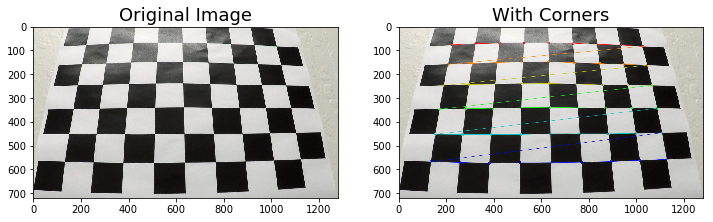

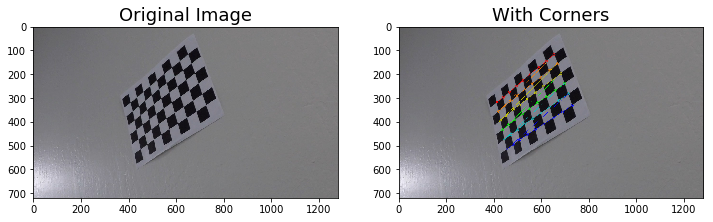

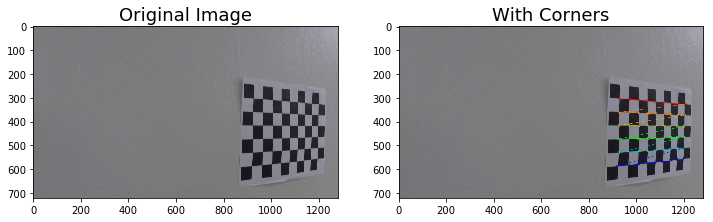

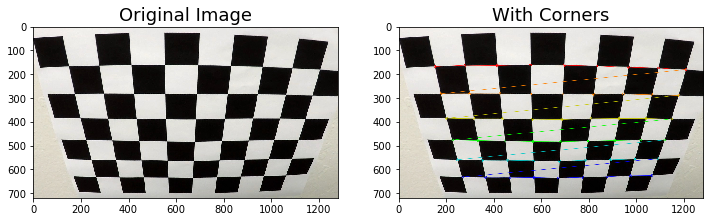

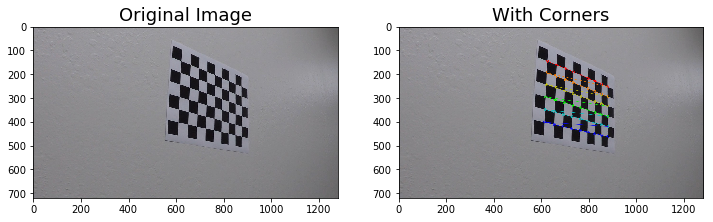

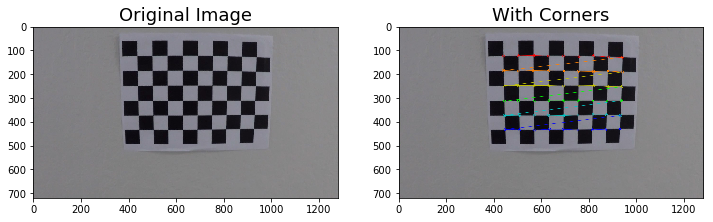

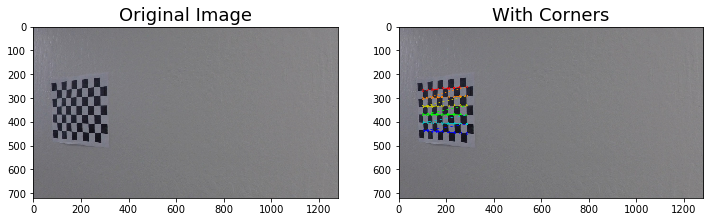

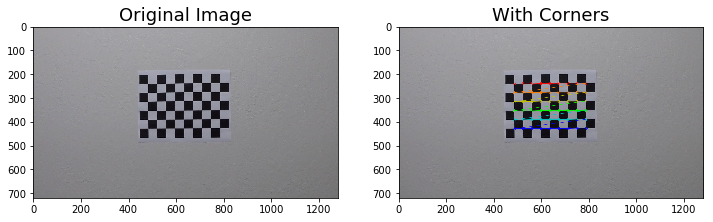

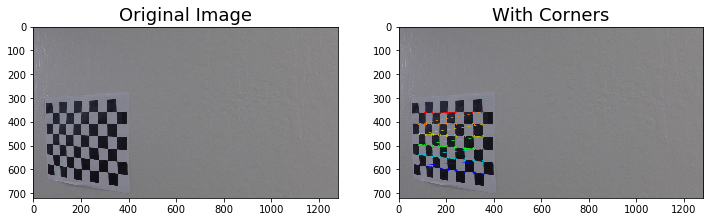

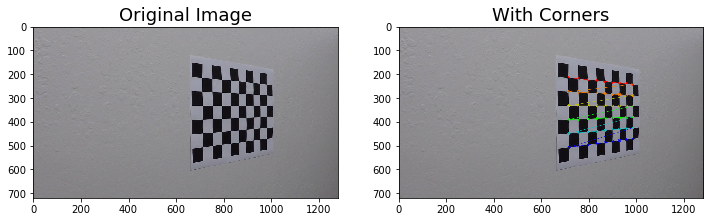

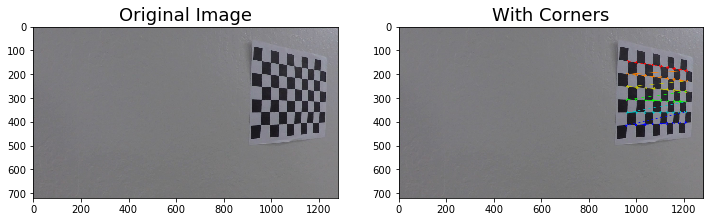

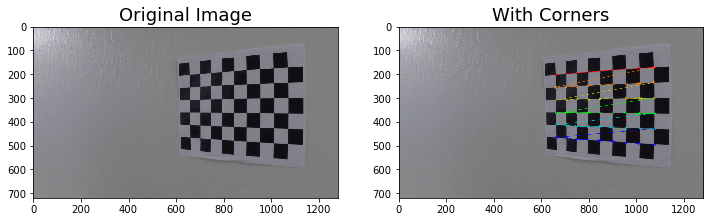

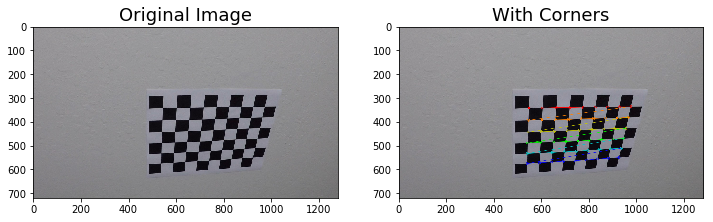

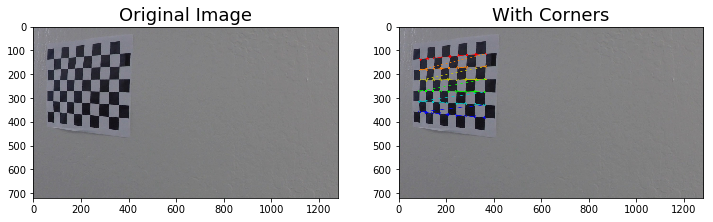

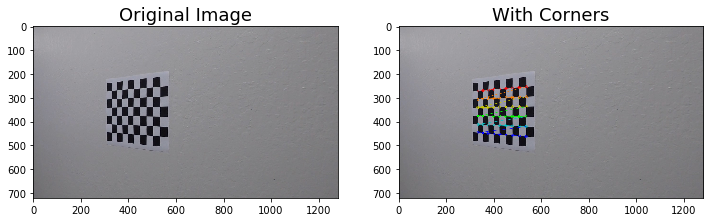

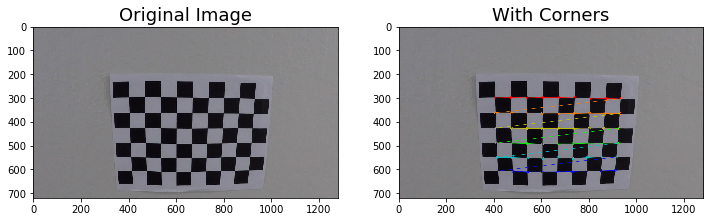

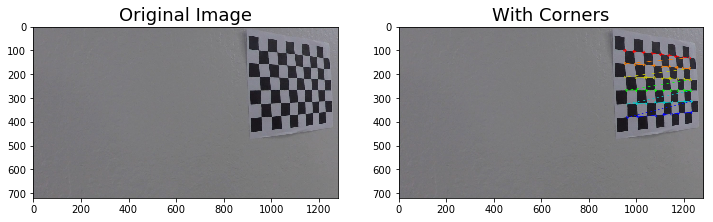

In [2]:
objp = np.zeros((6 * 9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

objpoints = []
imgpoints = []

images = glob.glob("camera_cal/calibration*.jpg")

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.imshow(cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title("Original Image", fontsize=18)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners', fontsize=18)

### Calibrate the Camera 

In [3]:
def calibrate_camera(image, objpoints, imgpoints):
    img_size = (image.shape[1], image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return mtx, dist

def undistort_image(image, mtx, dist):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist

#### Do some undistortion. 

Camera matrices mtx and dist are defined here

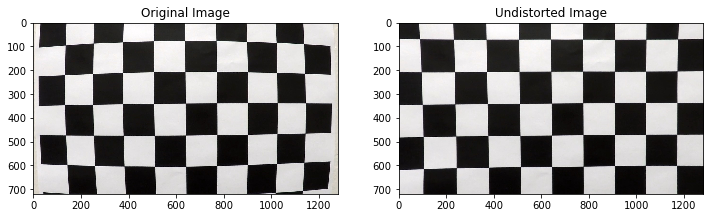

In [4]:
demo_image = cv2.imread('camera_cal/calibration1.jpg')
mtx, dist = calibrate_camera(demo_image, objpoints, imgpoints)
undist_demo = undistort_image(demo_image, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.imshow(cv2.cvtColor(demo_image, cv2.COLOR_BGR2RGB))
ax1.set_title("Original Image")
ax2.imshow(cv2.cvtColor(undist_demo, cv2.COLOR_BGR2RGB))
ax2.set_title("Undistorted Image")
plt.show()

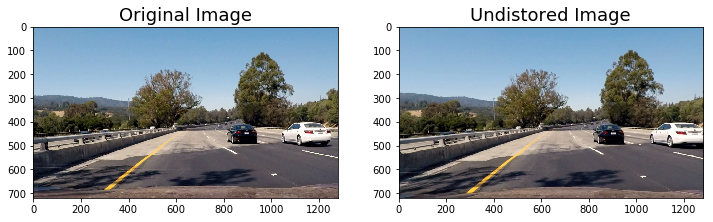

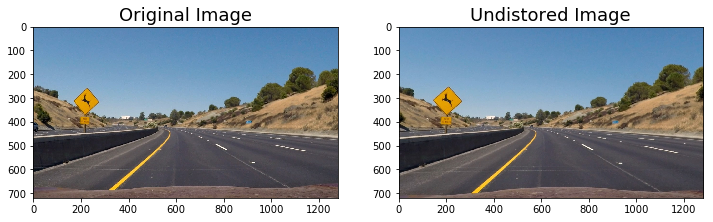

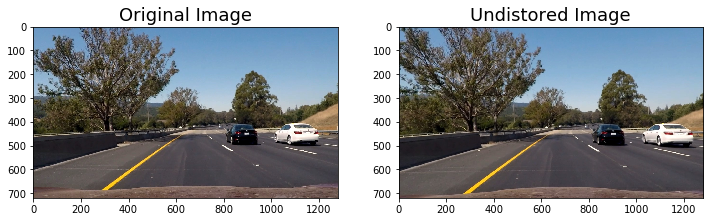

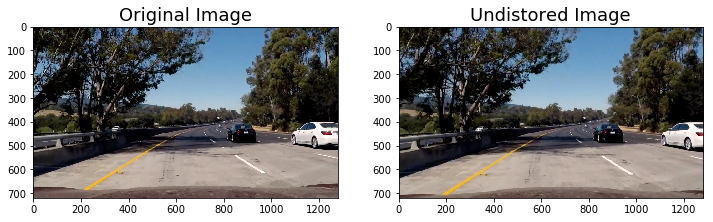

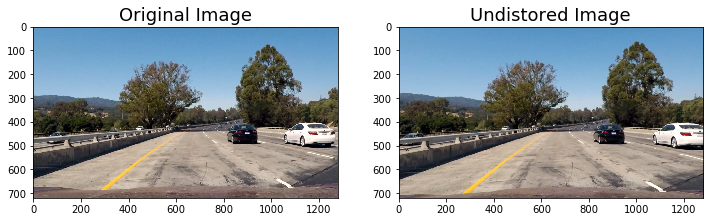

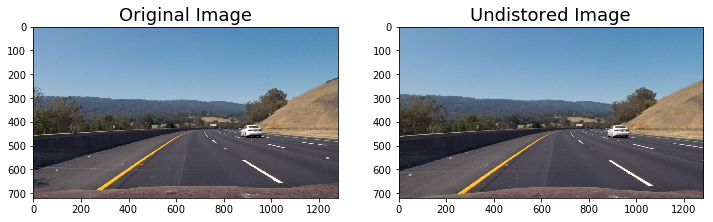

In [5]:
images = glob.glob('test_images/test*.jpg')
for image in images:
    image = cv2.imread(image)
    undist = undistort_image(image, mtx, dist)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=18)
    ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistored Image', fontsize=18)

### Functions to transform the images

In [6]:
def perspective_matrices(src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

def perspective_warp(image, M):
    image_size = (image.shape[0], image.shape[1])
    warped = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    return warped
    
def calculate_warp_points(imshape, x_center_adj=0):
    xcenter=imshape[1]/2+x_center_adj
    xfd=54
    yf=450
    xoffset=120
    src = np.float32(
        [(xoffset,imshape[0]),
         (xcenter-xfd, yf), 
         (xcenter+xfd,yf), 
         (imshape[1]-xoffset,imshape[0])])
    dst = np.float32(
        [(xoffset,imshape[1]),
         (xoffset,0),
         (imshape[0]-xoffset, 0),
        (imshape[0]-xoffset,imshape[1])])
    return src, dst

#### Demo of the transformations

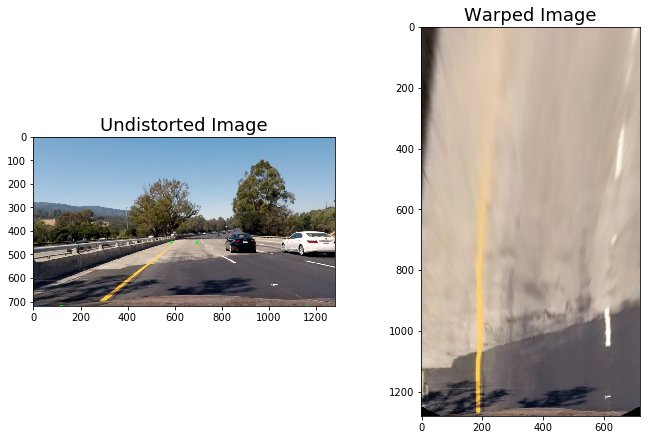

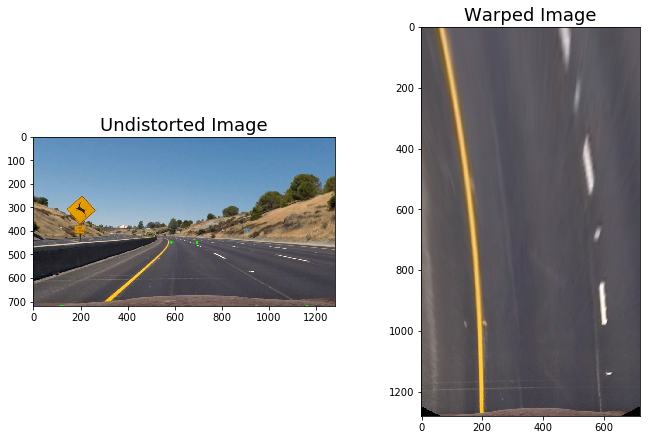

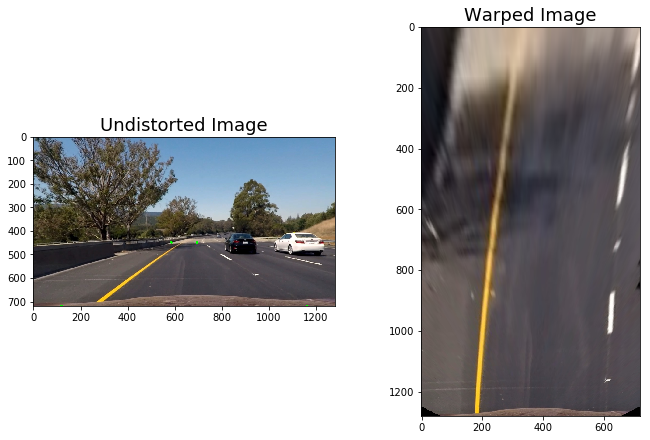

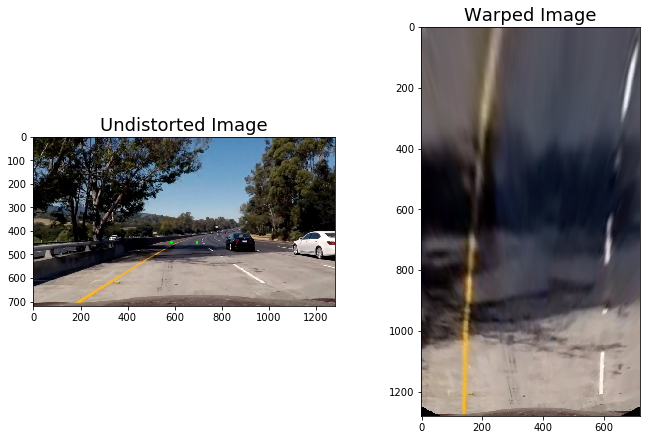

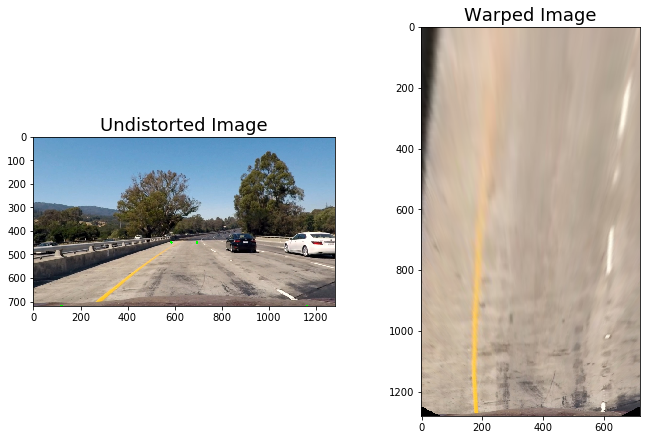

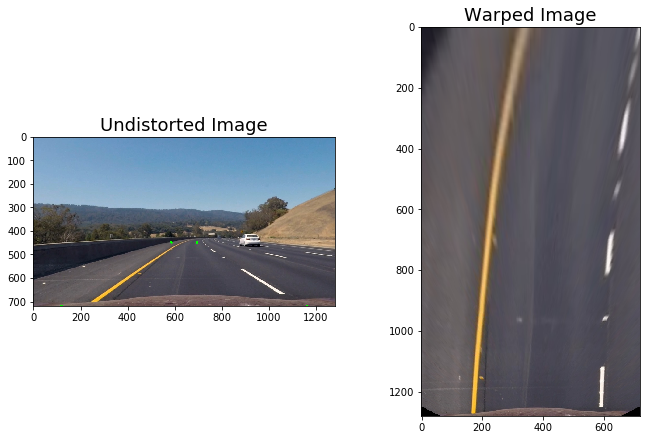

In [7]:
warped_images = []
for image in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(image)
    image = undistort_image(image, mtx, dist)
    src, dst = calculate_warp_points(image.shape)
    M, Minv = perspective_matrices(src, dst)
    warped_image = perspective_warp(image, M)
    
    
    for pt in src:
        cv2.circle(image, (int(pt[0]), int(pt[1])), 6, (0, 255, 0), -1)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.set_title('Undistorted Image', fontsize=18)
    ax2.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
    ax2.set_title('Warped Image', fontsize=18)
    plt.subplots_adjust(left=0., right=1., top=0.9, bottom=0.)

### Thresholding the images to detect lines in it.

In [8]:
def apply_thresholds(image, show=False):
    
    grad_thresh=(30,100)
    
    def binary_thresh(channel, thresh, on=1):
        binary = np.zeros_like(channel)
        binary[(channel > thresh[0]) & (channel <= thresh[1])] = on
        return binary
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    gradx = binary_thresh(scaled_sobelx, grad_thresh)
    
    abs_sobely = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    grady = binary_thresh(scaled_sobely, grad_thresh)
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    mag_thresh = (70, 100)
    mag_binary = binary_thresh(gradmag, mag_thresh)
    
    dir_thresh = (0.8, .9)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = binary_thresh(absgraddir, dir_thresh)
    
    s_channel = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)[:, :, 2]
    l_channel = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)[:, :, 0]
    b_channel = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)[:, :, 2]

    s_thresh_min = 210
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (l_binary == 1) | (b_binary == 1) | (mag_binary == 1)] = 1
    
    
    if show == True:
        f, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(18, 9))
        f.tight_layout()
        
        ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        
        ax2.imshow(gradx, cmap='gray')
        ax2.set_title('Gradx Image', fontsize=18)
        
        ax3.imshow(grady, cmap='gray')
        ax3.set_title('Grady Image', fontsize=18)
        
        ax4.imshow(mag_binary, cmap='gray')
        ax4.set_title("Grad Mag Image")
        
        ax5.imshow(dir_binary, cmap='gray')
        ax5.set_title("Grad Dir Image")
        
        ax6.imshow(s_binary, cmap='gray')
        ax6.set_title('S Threshold', fontsize=18)
        
        ax7.imshow(l_binary, cmap='gray')
        ax7.set_title('L Threshold', fontsize=18)
        
        ax8.imshow(b_binary, cmap='gray')
        ax8.set_title('B Threshold', fontsize=18)
        
        ax9.imshow(combined_binary, cmap='gray')
        ax9.set_title('Combnined Threshold', fontsize=18)
        
        ax10.axis('off')
        
    return combined_binary

#### Demo of the thresholding

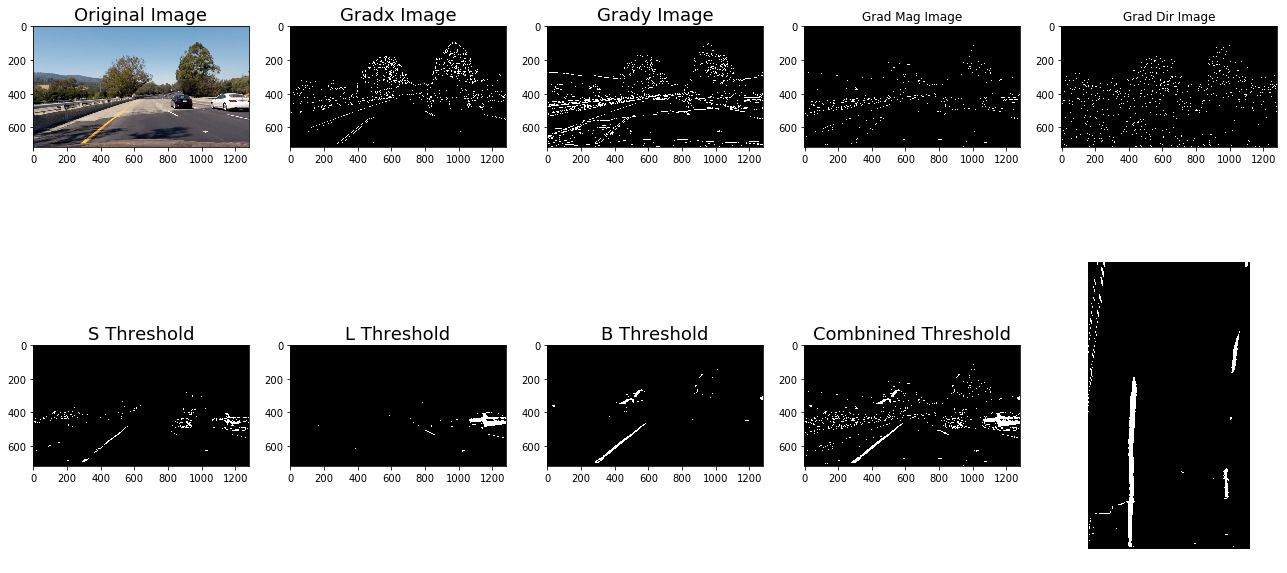

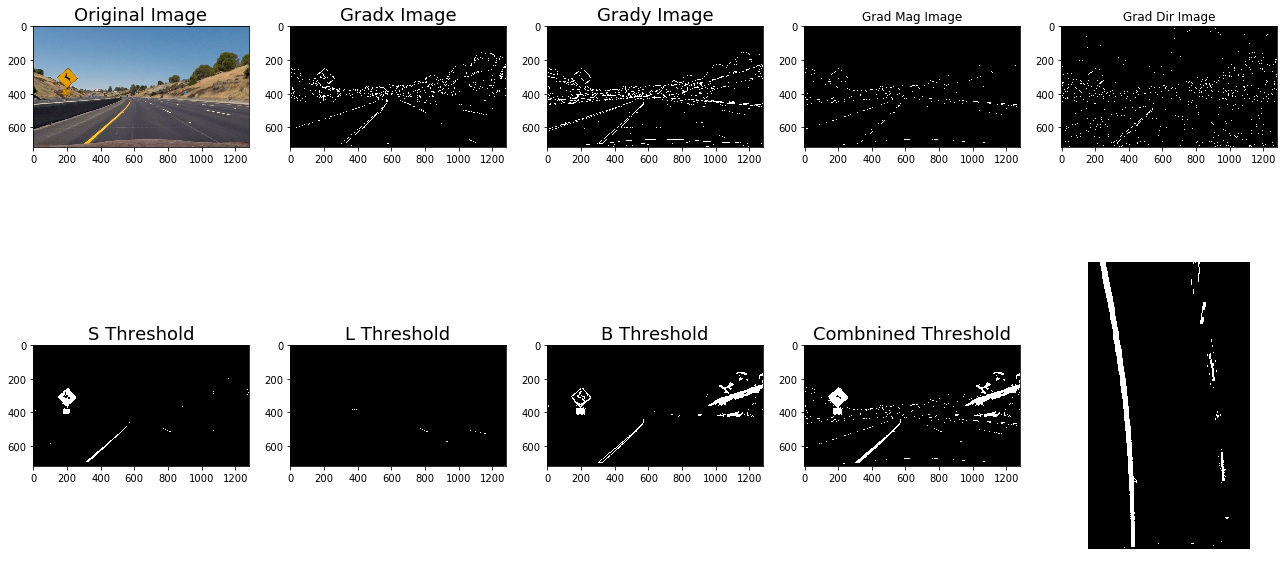

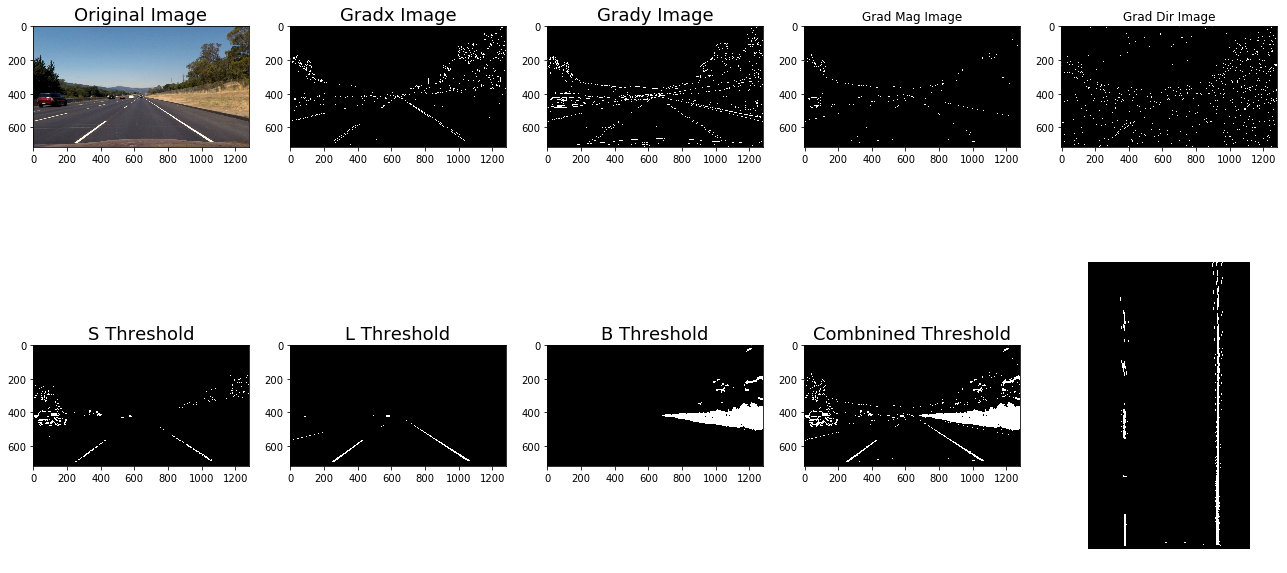

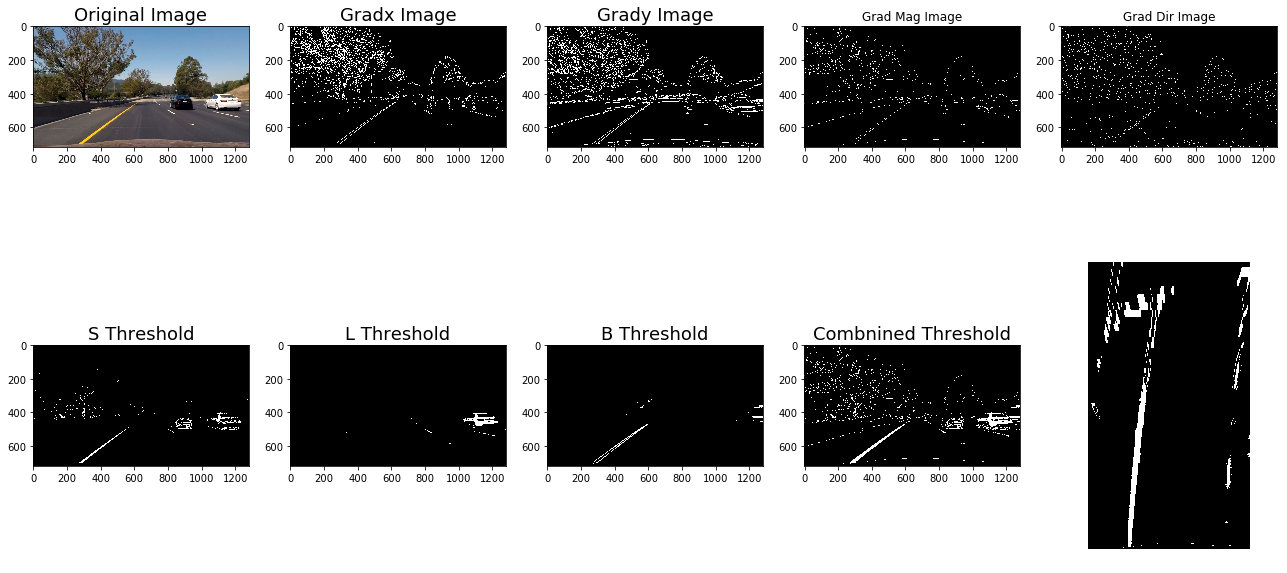

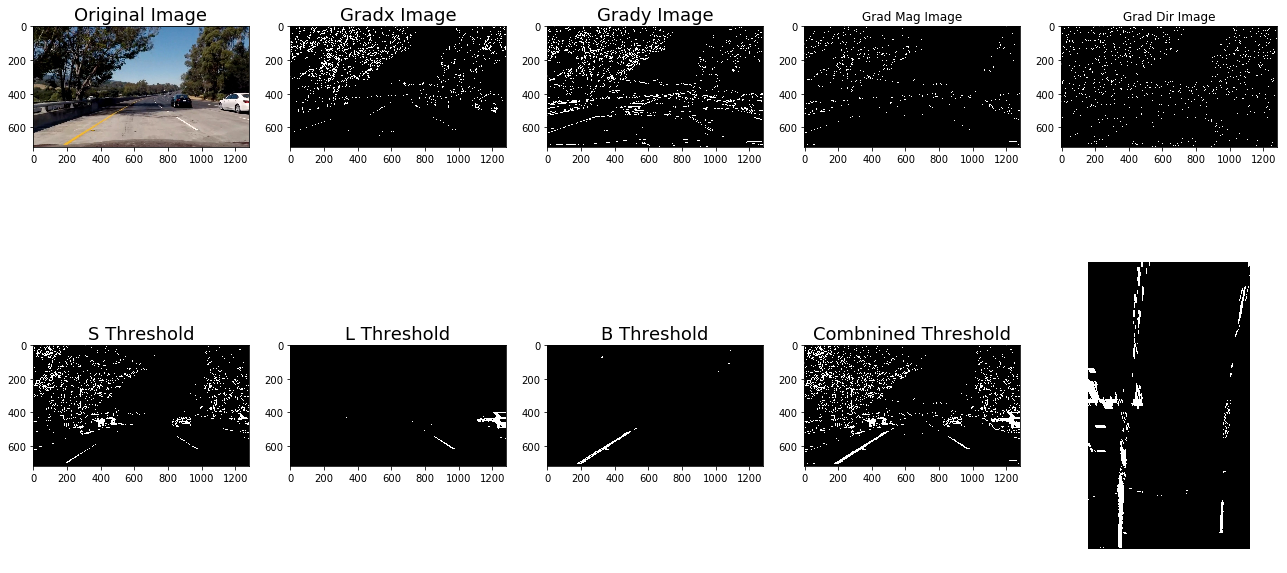

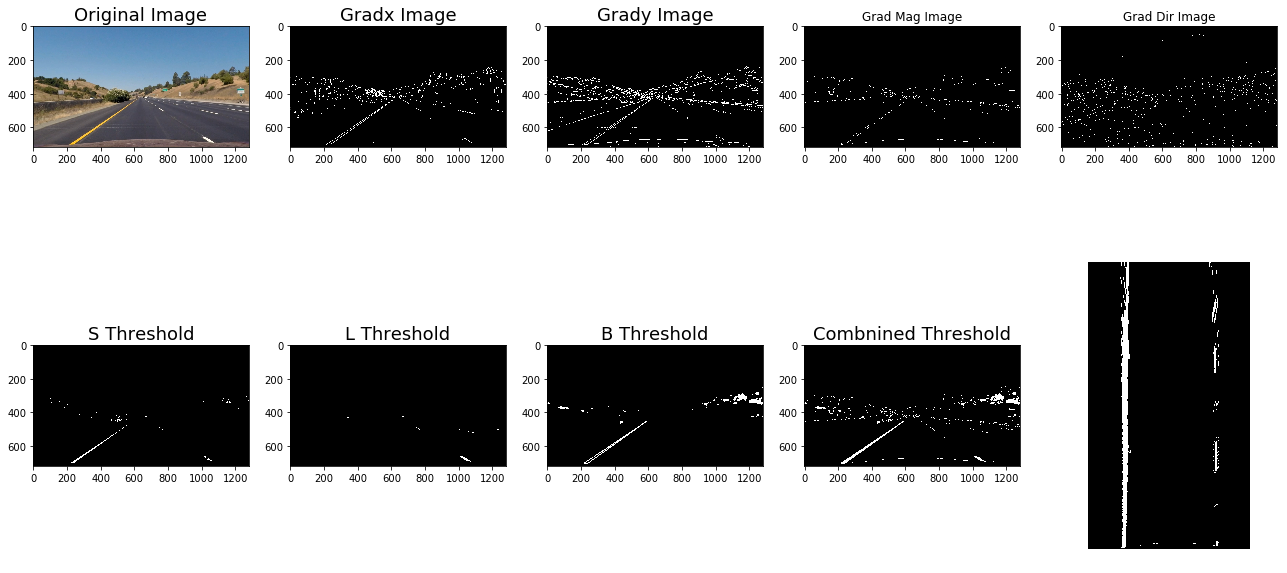

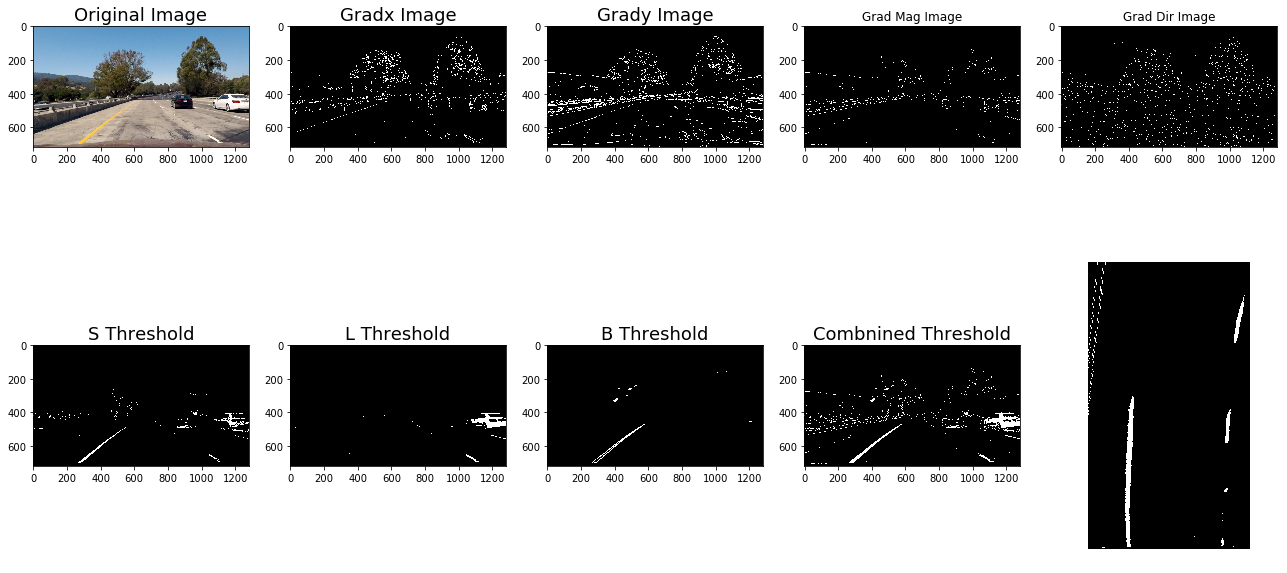

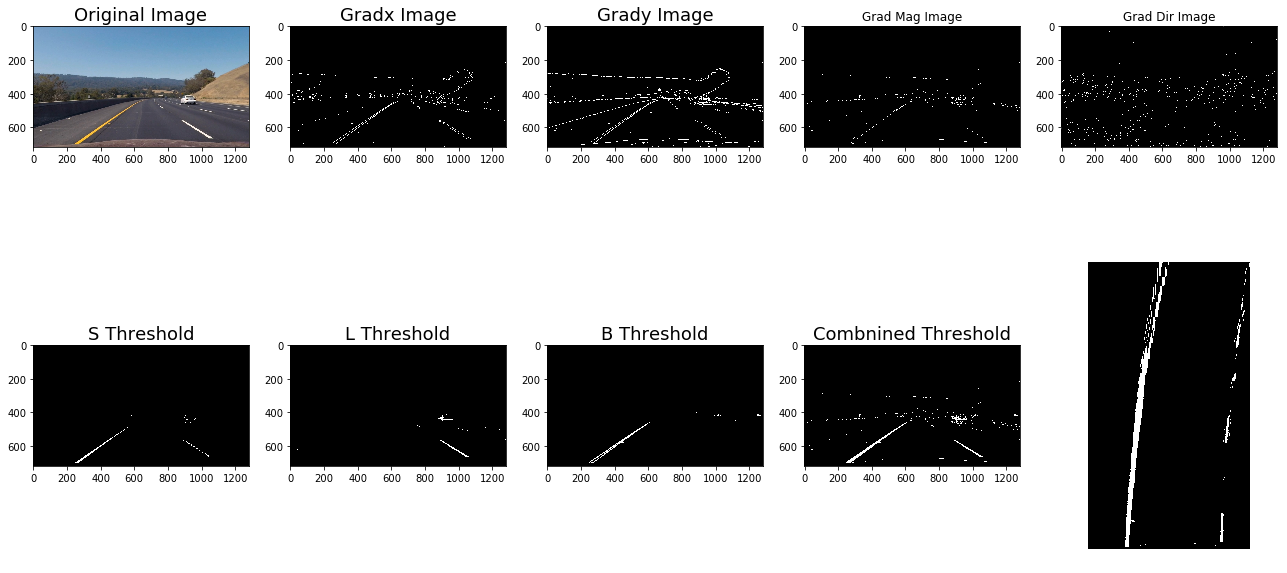

In [9]:
for image in glob.glob('test_images/*.jpg'):
    image = cv2.imread(image)
    image = undistort_image(image, mtx, dist)
    image = apply_thresholds(image, show=True)
    src, dst = calculate_warp_points(image.shape)
    M, Minv = perspective_matrices(src, dst)
    warped_image = perspective_warp(image, M)
    
    plt.imshow(warped_image, cmap='gray')

### Functions to find lane lines

In [10]:
from scipy import signal

def lane_histogram(img, height_start=800, height_end=1250):
    # Find the histogram from the bottom of the binary image
    histogram = np.sum(img[int(height_start):int(height_end),:], axis=0)
    return histogram

def lane_peaks(histogram):
    # Find the peaks of the histgram
    peaks = signal.find_peaks_cwt(histogram, np.arange(1,150),min_length=150)
    midpoint = np.int(histogram.shape[0]/2)
    # if we found at least two peaks use the signal approach (better in shadows)
    if len(peaks) > 1:
        # in case more then 2 found just get the left and right one
        peak_left, *_, peak_right = peaks
    # otherwise just choose the highest points in left and right of center segments
    else:
        peak_left = np.argmax(histogram[:midpoint])
        peak_right = np.argmax(histogram[midpoint:]) + midpoint
    return peak_left, peak_right

class SearchBox(object):
    def __init__(self, binimg, x_center, y_top, width=100, height=80, mincount=50, lane_found=False):
        self.x_center = x_center
        self.y_top = y_top
        self.width = width
        self.height = height
        self.mincount = mincount
        self.lane_found = lane_found
        self.x_left = self.x_center - int(self.width/2)
        self.x_right = self.x_center + int(self.width/2)
        self.y_bottom = self.y_top - self.height   
        self.imgwindow = binimg[self.y_bottom:self.y_top,self.x_left:self.x_right]
        self.nonzeroy = self.imgwindow.nonzero()[0]
        self.nonzerox = self.imgwindow.nonzero()[1]
         
    def center(self):
        return (self.x_center, int(self.y_top-self.y_bottom)/2)
    
    def next_searchbox(self, binimg):
        if self.has_line():
            # recenter based on mean
            x_center = np.int(np.mean(self.nonzerox + self.x_left))
        else:
            # use existing center
            x_center = self.x_center
        # next box top starts at lasts bottom
        y_top = self.y_bottom 
        return SearchBox(
            binimg, 
            x_center, 
            y_top, 
            width=self.width, height=self.height, 
            mincount = self.mincount,
            lane_found=self.lane_found
        )
    
    def _nonzerox_count(self):
        return len(self.nonzerox)
        
    def has_line(self):
        return (self._nonzerox_count() > self.mincount)
    
    def has_lane(self):
        if not self.lane_found and self.has_line():
            self.lane_found = True
        return self.lane_found



def find_lane_windows(window_box, binimg):
    boxes=[]
    # keep searching up the image for a lane line and append the boxes
    continue_lane_search = True
    contiguous_box_no_line_count = 0
    while (continue_lane_search and window_box.y_top >= 0):
        if window_box.has_line():
            boxes.append(window_box)
        window_box=window_box.next_searchbox(binimg)
        # if we've found the lane and can no longer find a box with a line in it
        # then its no longer worth while searching
        if window_box.has_lane():
            if window_box.has_line():
                contiguous_box_no_line_count = 0
            else:
                contiguous_box_no_line_count += 1
                if contiguous_box_no_line_count >= 5:
                    continue_lane_search = False
    return boxes
    
def calculate_lane_windows(binimg, nwindows=12, width=100):
    # calc height of each window
    height = np.int(binimg.shape[0]/nwindows)
    # find left and right lane centers to start with
    peak_left, peak_right = lane_peaks(lane_histogram(binimg))
    # Initialise left and right window boxes
    ytop = binimg.shape[0]
    wbl = SearchBox(binimg, peak_left, ytop, width=width, height=height)
    wbr = SearchBox(binimg, peak_right, ytop, width=width, height=height)
    # paralleise the search
    find_lane_windows_binimg = partial(find_lane_windows, binimg=binimg)
    with Pool(2) as p:
        left_boxes, right_boxes = p.map(find_lane_windows_binimg, [wbl, wbr])
    return (left_boxes, right_boxes)

def calculate_fit_from_boxes(boxes):
    if len(boxes) > 0:
        # flaten and adjust all boxes for the binary images
        xs = np.concatenate([b.nonzerox + b.x_left for b in boxes ])
        ys = np.concatenate([b.nonzeroy + b.y_bottom for b in boxes])
        # return the polynominal
        return np.polyfit(ys, xs, 2)
    else:
        return None

def poly_fitx(fity, line_fit):
    fit_linex = line_fit[0]*fity**2 + line_fit[1]*fity + line_fit[2]
    return fit_linex

def calc_lr_fit_from_polys(binimg, left_fit, right_fit, margin=100):
    nonzero = binimg.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    def window_lane(poly):
        return (
            (nonzerox > (poly[0]*(nonzeroy**2) + poly[1]*nonzeroy + poly[2] - margin)) 
            & (nonzerox < (poly[0]*(nonzeroy**2) + poly[1]*nonzeroy + poly[2] + margin))
        )
    
    def window_polyfit(lane_inds):
        xs = nonzerox[lane_inds]
        ys = nonzeroy[lane_inds]
        # return the polynominal
        return np.polyfit(ys, xs, 2)
    
    new_left_fit = left_fit
    if left_fit is not None: 
        new_left_fit = window_polyfit(window_lane(left_fit))
        
    new_right_fit =  right_fit
    if right_fit is not None: 
        new_right_fit = window_polyfit(window_lane(right_fit)) 
    
    return (new_left_fit, new_right_fit)

import matplotlib.patches as patches
from multiprocessing import Pool
import dill as pickle
from functools import partial

def test(image):
    topdown_binary_img = image
    height=topdown_binary_img.shape[0]

    histogram = lane_histogram(topdown_binary_img)
    peak_left, peak_right = lane_peaks(histogram)
    
    boxes_left, boxes_right = calculate_lane_windows(topdown_binary_img,width=150)

    left_fit = calculate_fit_from_boxes(boxes_left)
    right_fit = calculate_fit_from_boxes(boxes_right)
    
    # Generate x and y values for plotting
    fity = np.linspace(0, height-1, height)
    if left_fit is not None: 
        fit_leftx = poly_fitx(fity, left_fit)
    if right_fit is not None: 
        fit_rightx = poly_fitx(fity, right_fit)
    
    margin=100
    new_left_fit, new_right_fit = calc_lr_fit_from_polys(topdown_binary_img, left_fit, right_fit, margin)
    if new_left_fit is not None:
        new_leftx = poly_fitx(fity, new_left_fit)
    if new_right_fit is not None:    
        new_rightx = poly_fitx(fity, new_right_fit)
    
    figure, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(topdown_binary_img,cmap='gray')
    ax1.plot(height-histogram)
    ax1.plot((height,peak_left), (height,height-histogram[peak_left]), 'rx')
    ax1.plot((height,peak_right), (height,height-histogram[peak_right]), 'rx')
    for b in boxes_left + boxes_right:
        ax1.add_patch(patches.Rectangle((b.x_left, b.y_bottom),b.width,b.height,facecolor="none",edgecolor="green"))
    if left_fit is not None:
        ax1.plot(fit_leftx, fity, color='red')
    if right_fit is not None:
        ax1.plot(fit_rightx, fity, color='blue')
    ax1.set_xlim(0, 720)
    ax1.set_ylim(1280, 0)
    
    ax2.set_title("warped new polyfit from box seek poly")
    ax2.imshow(topdown_binary_img,cmap='gray')
    ax2.set_xlim(0, 720)
    ax2.set_ylim(1280, 0)
    if new_left_fit is not None:
        ax2.plot(new_leftx, fity, color='yellow')
        ax2.fill_betweenx(fity, new_leftx-margin,new_leftx+margin,alpha=0.25,color='green')
    if left_fit is not None:    
        ax2.fill_betweenx(fity, fit_leftx-margin,fit_leftx+margin,alpha=0.5,color='blue')
    if new_right_fit is not None:
        ax2.plot(new_rightx, fity, color='yellow')
        ax2.fill_betweenx(fity, fit_rightx-margin,fit_rightx+margin,alpha=0.5,color='blue')
    if right_fit is not None:
        ax2.fill_betweenx(fity, new_rightx-margin,new_rightx+margin,alpha=0.25,color='green')

##### Demo of lane finding.

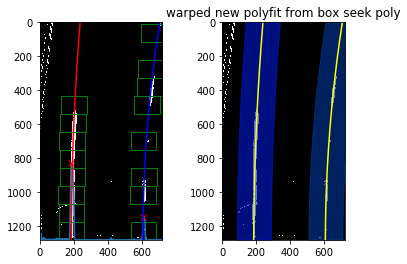

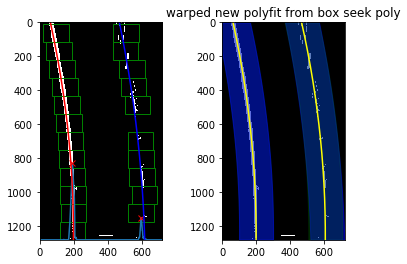

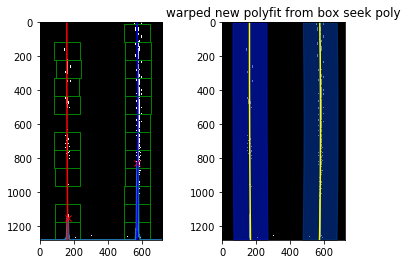

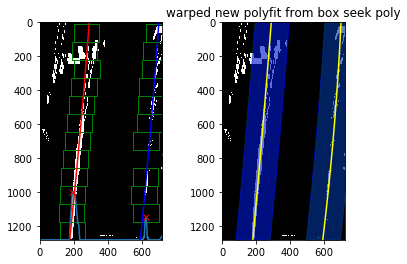

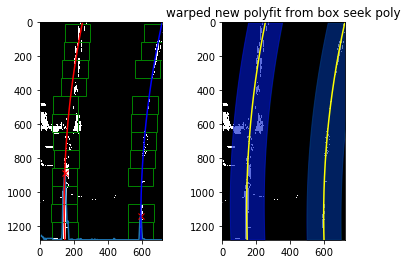

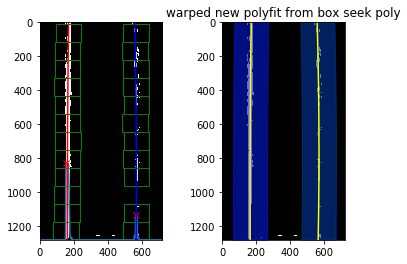

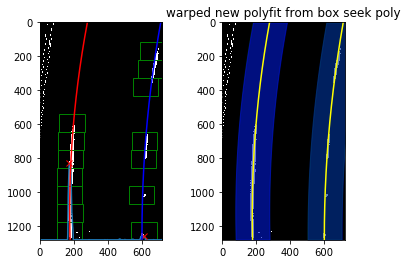

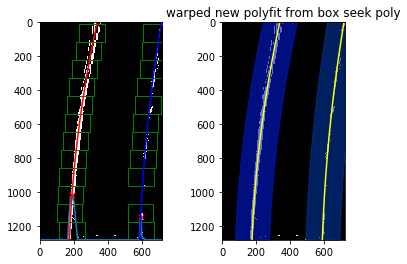

In [11]:
for image in glob.glob('test_images/*.jpg'):
    image = cv2.imread(image)
    image = undistort_image(image, mtx, dist)
    image = apply_thresholds(image, show=False)
    src, dst = calculate_warp_points(image.shape)
    M, Minv = perspective_matrices(src, dst)
    warped_image = perspective_warp(image, M)
    test(warped_image)

### Classes to handle lines across fames

In [12]:
def calc_curvature(poly, height=1280):
    fity = np.linspace(0, height-1, num=height)
    y_eval = np.max(fity)
    lane_px_height=275
    ym_per_pix = (10./lane_px_height) # meters per pixel in y dimension
    lane_px_width=413
    xm_per_pix = 3.7/lane_px_width
    
    def fit_in_m(poly):
        xs = poly_fitx(fity, poly)
        xs = xs[::-1] # Reverse to match top-to-bottom in y
        return np.polyfit(fity*ym_per_pix, xs*xm_per_pix, 2)
    
    if poly is None:
        return .0
    
    poly_cr = fit_in_m(poly)
    curveradm = ((1 + (2*poly_cr[0]*y_eval*ym_per_pix + poly_cr[1])**2)**1.5) / np.absolute(2*poly_cr[0])
    return curveradm



In [13]:
from collections import deque

class Line():
    """Line Class"""
    def __init__(self, ploty, poly_fit, binimg):
        self.__ploty = ploty
        self.__poly_fit = poly_fit
        self.__binimg = binimg
        
        # derived
        self.__curvature = None
        self.__y_bottom = np.min(ploty)
        self.__y_top = np.max(ploty)
        
        self.__x_bottom = poly_fitx(self.__y_bottom, self.poly_fit)
        self.__x_top = poly_fitx(self.__y_top, self.poly_fit)
        
    @property
    def xs(self):
        return poly_fitx(self.ploty, self.poly_fit)
    
    @property
    def ploty(self):
        return self.__ploty
    
    @property
    def poly_fit(self):
        return self.__poly_fit
    
    @property
    def binimg(self):
        return self.__binimg
    
    @property
    def y_bottom(self):
        return self.__y_bottom
    
    @property
    def y_top(self):
        return self.__binimg.shape[1]
    
    @property
    def x_bottom(self):
        return self.__x_bottom

    @property
    def x_top(self):
        return self.__x_top
    
    @property
    def curvature(self):
        if self.__curvature is None:
            self.__curvature = calc_curvature(self.poly_fit)
        return self.__curvature

In [14]:
class LaneLine():
    def __init__(self, line, line_history_max=6):
        # initialise class
        self.__line_history = deque([])
                
        self.__all_curvatures = None
        
        self.line_history_max = line_history_max
        self.line = line 
        
    # If there are lines in the history return the last one.
    @property
    def line(self):
        if len(self.__line_history) > 0:
            return self.__line_history[-1]
        else:
            return None
    
    @line.setter
    def line(self, line):
        
        def xs_are_near(x1,x2, limit=100):
            return np.abs(x1-x2) < limit
        
        def is_line_sane(line):
            line_prev = self.line
            if not xs_are_near(line.x_top,line_prev.x_top):
                return False
            # bottom is horizon
            if not xs_are_near(line.x_bottom,line_prev.x_bottom):
                return False    
            return True
            
        if len(self.__line_history) > 0 and not is_line_sane(line):
            return
        self._queue_to_history(line)
        
    def _queue_to_history(self, line):
        self.__line_history.append(line)
        self.__all_curvatures = None 
        if self.line_history_count > self.line_history_max:
            self.__line_history.popleft()
        
    @property
    def line_history_count(self):
        return len(self.__line_history) 
    
    @property
    def curvature(self):
        return self.line.curvature
    
    @property
    def curvatures(self):
        if self.__all_curvatures is None:
            self.__all_curvatures = np.array([line.curvature for line in self.__line_history])
        return self.__all_curvatures
    
    @property
    def mean_curvature(self):
        return np.mean(self.curvatures)
    
    @property
    def line_fits(self):
        return np.array([line.poly_fit for line in self.__line_history])
    
    @property
    def mean_fit(self):
        lf=self.line_fits
        nweights=len(lf)
        
        weights = None
        # if just one no need for weights
        if nweights > 1:
            # if two then give more weight to the newer
            if nweights == 2:
                weights = [.60,.40]
            # otherwise start with two and pad out evenly the remainder
            else:
                weights = [.40,.30]

                # pad out the weights 
                if nweights > len(weights):
                    weights=np.pad(weights,(0,nweights-len(weights)),'constant', 
                             constant_values=(1-np.sum(weights))/(nweights-len(weights)))
            
            
        return np.average(lf, weights=weights, axis=0)
       
    @property
    def ploty(self):
        return self.line.ploty
    
    @property
    def mean_xs(self):
        return poly_fitx(self.ploty, self.mean_fit)

In [17]:
class Lane():
    lane_px_width=413
    xm_per_pix = 3.7/lane_px_width 
    
    def __init__(self, img_height, img_width, mtx, dist):
        self.__img_height = img_height
        self.__img_width = img_width
        
        # camera callibration
        self.__mtx = mtx
        self.__dist = dist

        # set images to None
        self.__image = None 
        self.__undistorted_image = None
        self.__binary_image = None
        self.__warped = None

        # warp points and transformation matrices
        warp_src, warp_dst = calculate_warp_points((img_height, img_width))
        self.__warp_src = warp_src
        self.__warp_dst = warp_dst
        M, Minv = perspective_matrices(warp_src, warp_dst)
        self.__M = M
        self.__Minv = Minv
        
        warped_height=img_width
        self.__ploty = np.linspace(0,warped_height-1, warped_height)
        self.__pts_zero = np.zeros((1,warped_height,2),dtype=np.int)
        
        self.__road_line_left = None
        self.__road_line_right = None
           
    @property
    def img_height(self):
        return self.__img_height
    @property
    def img_width(self):
        return self.__img_width  
    
    @property
    def pts_zero(self):
        return self.__pts_zero
    
    @property 
    def ploty(self):
        return self.__ploty

    @property
    def undistorted_image(self):
        return self.__undistorted_image
        
    @property
    def binary_image(self):
        return self.__binary_image
    
    @property
    def warped(self):
        return self.__warped
    
    @property
    def warped_threshold(self):
        return self.__warped_threshold
    
    @property
    def road_line_left(self):
        return self.__road_line_left
   
    @property
    def road_line_right(self):
        return self.__road_line_right
    
    @property
    def result(self):
        result = self._draw_lanes_unwarped()
        return result
    
    @property
    def result_decorated(self):
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        rll, rlr = self.road_line_left, self.road_line_right
        cl, clm = rll.curvature, rll.mean_curvature
        cr, crm = rlr.curvature, rlr.mean_curvature
        xcoffset = self.x_center_offset
        
        result = self.result
        result = cv2.putText(result,'Left Curve: %0.2f' % cl, (5,50), font, 1, (255,255,255), 2, cv2.LINE_AA)
        result = cv2.putText(result,'Mean Left Curve: %0.2f' % clm, (5, 100), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
        result = cv2.putText(result,'Right Curve: %0.2f' % cr, (950,50), font, 1, (255,255,255), 2, cv2.LINE_AA)
        result = cv2.putText(result,'Mean Right Curve: %0.2f' % crm, (855, 100), font, 1, (255, 255, 255), 2, cv2.LINE_AA) 
        result = cv2.putText(result,'Lane Center Offset: %.3f' % xcoffset, (460, 700), font, 1,(255,255,255),2,cv2.LINE_AA)
        
        return result
    
    @property
    def image(self):
        return self.__image

    @image.setter
    def image(self, image):
        # make sure its a bgr image being passed in
        self.__image = image
        undistorted = undistort_image(self.__image, self.__mtx, self.__dist)
        self.__undistorted_image = undistorted
           
        # look for a warp that isnt too noisy 
        self.__binary_image, self.__warped = self._undistort_warp_search(undistorted)
        
        # first time start with a full search to prime left & right road line objects
        if self.road_line_left is None and self.road_line_right is None:
            self._full_histogram_lane_search()
        
        # left & right recalc using previous polynominal fit
        else:
            self._recalc_road_lines_from_polyfit()
    
    def _undistort_warp_search(self, undistorted):
        # intitial threshold
        binary_image, warped = self._warp_undistorted_threshold(undistorted)    
        return (binary_image, warped)
    
    def _warp_undistorted_threshold(self, undistorted_image):
        binary_image = apply_thresholds(undistorted_image)
        warped = perspective_warp(binary_image, self.__M)
        return (binary_image, warped)
    
    @property
    def x_center_offset(self):    
        lx = self.x_start_left
        rx = self.x_start_right
        lanecenter = rx - ((rx - lx) / 2)
        xcenter = np.int(self.warped.shape[1]/2)
        
        offset = lanecenter - xcenter 
        return self._x_pix_to_m(offset)
    
    @property
    def x_start_left(self):      
        return self.road_line_left.line.x_top
    
    @property
    def x_start_right(self):
        return self.road_line_right.line.x_top
    
    def _x_pix_to_m(self, pix):
        return pix* self.xm_per_pix
    
    def _full_histogram_lane_search(self):
        histogram = self.warped_histogram
        peak_left, peak_right = lane_peaks(histogram)
        
        self.__road_line_left = LaneLine(self._road_line_box_search(peak_left))
        self.__road_line_right = LaneLine(self._road_line_box_search(peak_right))
        
    @property
    def warped_histogram(self):
        height = self.warped.shape[0]
        return lane_histogram(self.warped,int(height/2),height)
    
    def _road_line_box_search(self, x_start,  nwindows=12, width=100):
    
         # Initialise left and right window boxes
        ytop = self.warped.shape[0]
        # calc height of each window
        height = np.int(ytop/nwindows)
        
        wb = SearchBox(self.warped, x_start, ytop, width=width, height=height)
        boxes = find_lane_windows(wb, self.warped)
        
        poly_fit = calculate_fit_from_boxes(boxes)
            
        line = Line(self.ploty, poly_fit, self.warped)
        
        return line
    
    def _recalc_road_lines_from_polyfit(self, margin=25):
        # the last polynominal line fits
        left_fit = self.road_line_left.line.poly_fit
        right_fit = self.road_line_right.line.poly_fit
        
        new_left_fit, new_right_fit = calc_lr_fit_from_polys(self.warped, left_fit, right_fit, margin)
        
        
        self.road_line_left.line = self._line_from_fit(new_left_fit)
        if self.road_line_left.line is None:
            self.road_line_left.line = self._line_from_fit(left_fit)
                
        
        self.road_line_right.line = self._line_from_fit(new_right_fit)
        if self.road_line_right.line is None:
            self.road_line_right.line = self._line_from_fit(right_fit)
        
    def _line_from_fit(self, new_fit):
        # if we dont have a polynominal fit use the last 
        new_line = None
        if new_fit is None:
            return None
        line = Line(self.ploty, new_fit, self.warped)
        return line

    
    def _draw_lanes_unwarped(self):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(self.warped).astype(np.uint8)
        # Draw the pale lane on it
        color_warp=np.dstack((warp_zero, warp_zero, warp_zero))
        # Draw lane lines here 
        sides_warp=np.dstack((warp_zero, warp_zero, warp_zero))
        # Get the points
        pts_left, pts_right = self.pts_zero, self.pts_zero
        # Get the mean points
        mean_xs_left, mean_xs_right = self.road_line_left.mean_xs, self.road_line_right.mean_xs
        # Change these to be plotable
        pts_left = np.array([np.transpose(np.vstack([mean_xs_left, self.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([mean_xs_right, self.ploty])))])
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts = np.hstack((pts_left, pts_right))
        # Draw Lane lines
        cv2.polylines(sides_warp, np.int_([pts_left]), False, color=(255, 0, 0), thickness=12)
        cv2.polylines(sides_warp, np.int_([pts_right]), False, color=(0, 0, 255), thickness=12)
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        # Warp the draw images back to the right shape
        newwarp = perspective_warp(color_warp, self.__Minv) 
        sidewarp = perspective_warp(sides_warp, self.__Minv)
        # Combine the result with the original image
        result = cv2.addWeighted(self.undistorted_image, 1, newwarp, 0.3, 0)
        result = cv2.addWeighted(result, 1, sidewarp, 1, 0)
        return result

In [19]:
def do_project_video(file_name, output_name):
    height, width = (720,1280)
    lane = Lane(height, width, mtx, dist)
    
    def process_image(image):
        # process the lane image
        lane.image = image
        result = lane.result_decorated        
        return result

    clip1 = VideoFileClip(file_name)
    lane_clip = clip1.fl_image(process_image) 
    %time lane_clip.write_videofile(output_name, audio=False)
    
    return lane_clip

lane_clip = do_project_video("project_video.mp4","project_video_lane.mp4")

[MoviePy] >>>> Building video project_video_lane.mp4
[MoviePy] Writing video project_video_lane.mp4


100%|█████████▉| 1260/1261 [04:45<00:00,  4.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_lane.mp4 

CPU times: user 10min 25s, sys: 1.96 s, total: 10min 27s
Wall time: 4min 46s
